In this notebook we will make some data exploration to have a better understanding of the structure of the data

The notebook goes as:
1. [Train dataset exploration](#train-dataset-exploration)
2. [Bounding boxes exploration](#bouding-boxes-exploration)

# Train dataset exploration

In [2]:
import pandas as pd

df_ground_truth = pd.read_csv('./train.csv')
df_ground_truth.head()

,frame_id,bounding_boxes
0,train/A_001.jpg,0 225 214 317 0 172 345 254 285 240 155 131 70...
1,train/A_002.jpg,0 254 190 293 0 169 338 271 276 238 160 137 70...
2,train/A_003.jpg,0 306 59 241 0 155 306 318 235 233 191 149 713...
3,train/A_004.jpg,0 143 239 298 164 223 240 172 721 293 94 76 57...
4,train/A_005.jpg,0 217 137 270 55 209 323 208 731 296 99 79 573...


In [3]:
print("length of the bounding boxes of image 0: ", len(df_ground_truth["bounding_boxes"][0]))
print("length of the bounding boxes of image 10: ", len(df_ground_truth["bounding_boxes"][10]))

length of the bounding boxes of image 0:  200
length of the bounding boxes of image 10:  214


### Algorithmes

In [4]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread


H, W = 720, 1280
N = len(df_ground_truth)


def read_frame(df_annotation, frame):
    """Read frames and create integer frame_id-s"""
    file_path = df_annotation[df_annotation.index == frame]['frame_id'].values[0]
    return imread(file_path)

def annotations_for_frame(df_annotation, frame):
    assert frame in df_annotation.index
    bbs = df_annotation[df_annotation.index == frame].bounding_boxes.values[0]

    if pd.isna(bbs): # some frames contain no vehicles
        return []

    bbs = list(map(lambda x : int(x), bbs.split(' ')))
    return np.array_split(bbs, len(bbs) / 4)

def show_annotation(df_annotation, frame):
    img = read_frame(df_annotation, frame)
    bbs = annotations_for_frame(df_annotation, frame)

    fig, ax = plt.subplots(figsize=(10, 8))

    for x, y, dx, dy in bbs:

        rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))

def bounding_boxes_to_mask(bounding_boxes, H, W):
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """

    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]

    if len(non_zeros) == 0:
        return ''

    padded = np.pad(non_zeros, pad_width=1, mode='edge')

    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

In [5]:
bbs = annotations_for_frame(df_ground_truth, 0)
print("#"*20,"image 0","#"*20)
print("BBS", bbs)
print("Raw data:", df_ground_truth["bounding_boxes"][0])

#################### image 0 ####################
BBS [array([  0, 225, 214, 317]), array([  0, 172, 345, 254]), array([285, 240, 155, 131]), array([706, 294,  84,  67]), array([565, 284,  68,  55]), array([1002,  309,   56,   40]), array([678, 293,  48,  44]), array([478, 278,  32,  31]), array([611, 284,  26,  27]), array([436, 280,  41,  26]), array([938, 295, 102,  45]), array([518, 282,  59,  20]), array([1216,  305,   61,   49]), array([428, 284,  18,  15])]
Raw data: 0 225 214 317 0 172 345 254 285 240 155 131 706 294 84 67 565 284 68 55 1002 309 56 40 678 293 48 44 478 278 32 31 611 284 26 27 436 280 41 26 938 295 102 45 518 282 59 20 1216 305 61 49 428 284 18 15


### Scenes 

Each scene has a duration of 202 frames

### Looking for empty pictures

In [6]:
path = "train.csv"
df_ground_truth["bounding_boxes"].isna().count()

2222

### Size of individual images

In [7]:
print("Size of images is:",imread(df_ground_truth.iloc[0]["frame_id"]).shape)

Size of images is: (720, 1280, 3)


# Bouding Boxes exploration

In [136]:
x_arr = []
dx_arr = []
y_arr = []
dy_arr = []

for row in df_ground_truth["bounding_boxes"]:
        try:
                row = row.split(" ")
                boxes = np.array_split(row, len(row) / 4)
                for x,y, dx, dy in boxes:
                        x_arr.append(x)
                        dx_arr.append(dx)
                        y_arr.append(y)
                        dy_arr.append(dy)
        except: 
                pass

df_gt_data_info = pd.DataFrame(data=  {"x": x_arr,"y": y_arr, "w": dx_arr,"h": dy_arr})
df_gt_data_info.head()

,x,y,w,h
0,0,225,214,317
1,0,172,345,254
2,285,240,155,131
3,706,294,84,67
4,565,284,68,55


Lets see the position of the different outliers for each position. The idea here is to see if some parts the image are never apart of bouding boxes

In [142]:
# sort the x
x_df  = df_gt_data_info["x"].value_counts()
x_df.index= x_df.index.astype(int)
x_df= x_df.sort_values()

# sort the y
y_df  = df_gt_data_info["y"].value_counts()
y_df.index= y_df.index.astype(int)
y_df= y_df.sort_values()

# sort the w
w_df  = df_gt_data_info["w"].value_counts()
w_df.index= w_df.index.astype(int)
w_df= w_df.sort_values()

# sort the h
h_df  = df_gt_data_info["h"].value_counts()
h_df.index= h_df.index.astype(int)
h_df= h_df.sort_values()

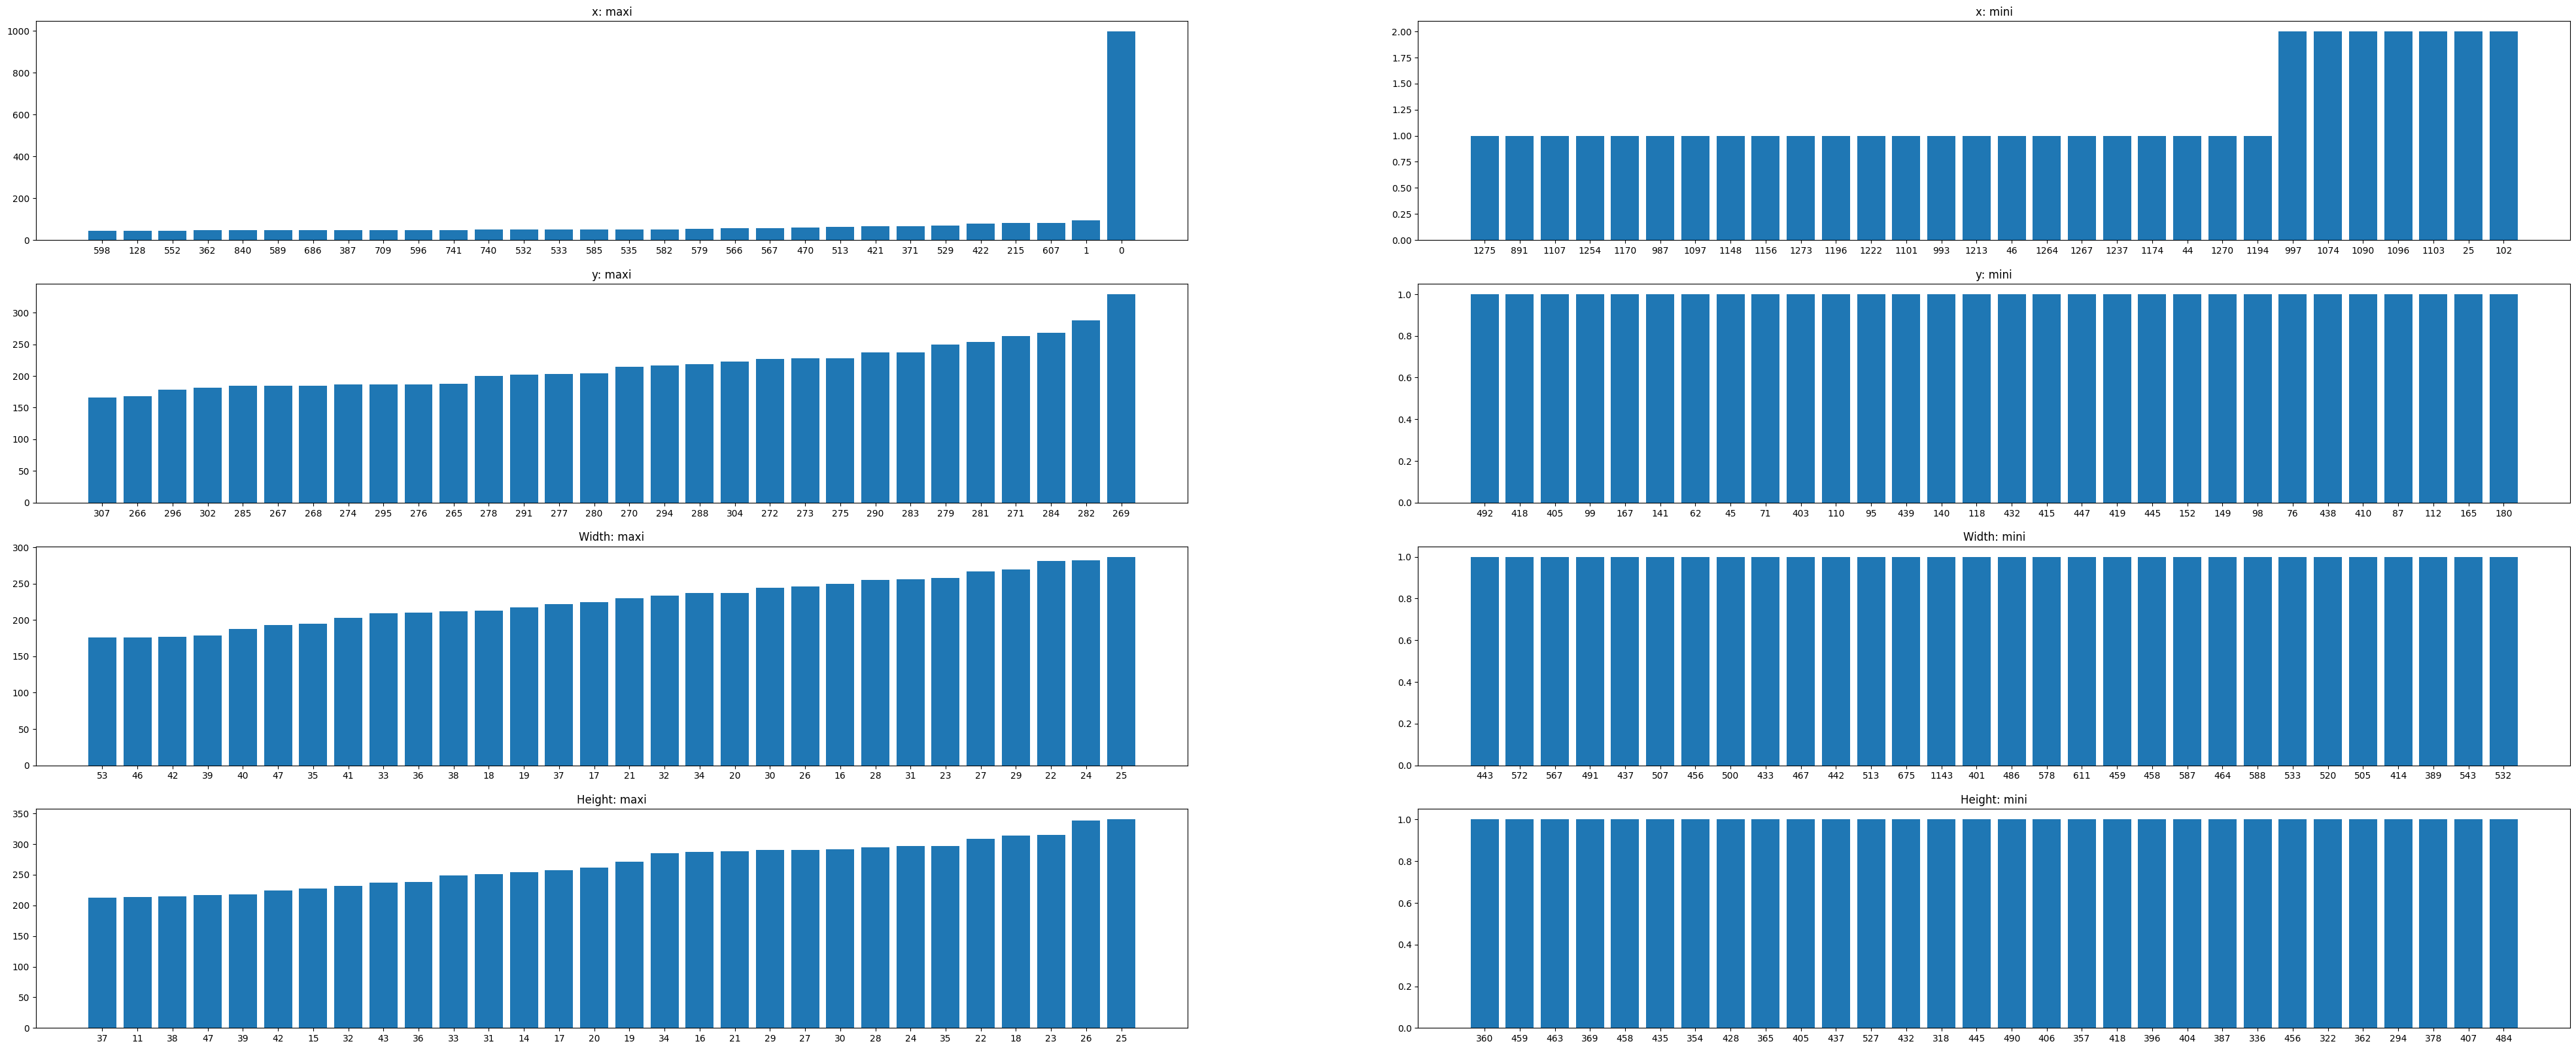

In [164]:
fig, ax = plt.subplots(4,2,figsize=(50,20))
ax[0][0].bar(x_df.index.values[-30:].astype(str),x_df.values[-30:])
ax[0][1].bar(x_df.index.values[:30].astype(str), x_df.values[:30])
ax[1][0].bar(y_df.index.values[-30:].astype(str),y_df.values[-30:])
ax[1][1].bar(y_df.index.values[:30].astype(str), y_df.values[:30])
ax[2][0].bar(w_df.index.values[-30:].astype(str),w_df.values[-30:])
ax[2][1].bar(w_df.index.values[:30].astype(str), w_df.values[:30])
ax[3][0].bar(h_df.index.values[-30:].astype(str),h_df.values[-30:])
ax[3][1].bar(h_df.index.values[:30].astype(str), h_df.values[:30])

ax[0][0].set_title("x: maxi")
ax[0][1].set_title("x: mini")
ax[1][0].set_title("y: maxi")
ax[1][1].set_title("y: mini")
ax[2][0].set_title("Width: maxi")
ax[2][1].set_title("Width: mini")
ax[3][0].set_title("Height: maxi")
ax[3][1].set_title("Height: mini")
plt.show()

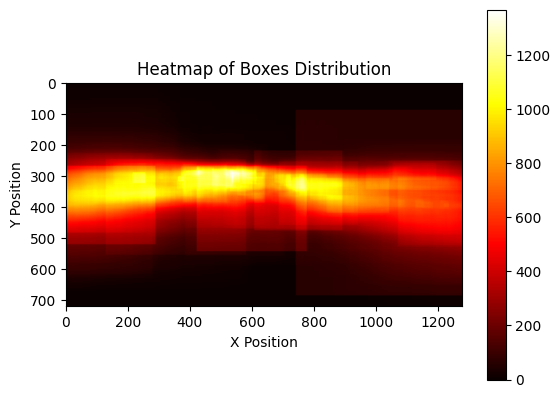

In [201]:
import matplotlib.pyplot as plt

# Define the image size
img_size = (1280, 720)

# Initialize an empty 2D array to store the counts
counts = [[0 for j in range(img_size[1])] for i in range(img_size[0])]

# Loop through each rectangle and update the counts in the corresponding region of the array
for index, row in df_gt_data_info.iterrows():
    x, y, w, h = int(row['x']), int(row['y']), int(row['w']), int(row['h'])
    if x + w < img_size[0] and y + h < img_size[1]:
        for i in range(x, x+w):
            for j in range(y, y+h):
                counts[i][j] += 1
    else :
        for i in range(x):
            for j in range(y):
                counts[i][j] += 1
# Create the heatmap
plt.imshow(np.transpose(np.array(counts)), cmap='hot')
plt.colorbar()
plt.title('Heatmap of Boxes Distribution')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


Conclusion: To gain computation time we will not look for boxes when y > 500 and y< 200